# Nicolas's Original Code

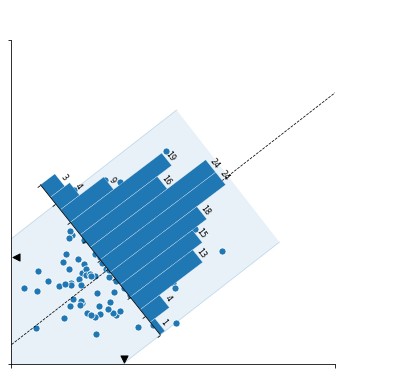

In [20]:
# ----------------------------------------------------------------------------
# Title:   Scientific Visualisation - Python & Matplotlib
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
# Illustrate rotated & translated axis (using axisartists toolkit)
# ----------------------------------------------------------------------------
# https://github.com/rougier/scientific-visualization-book/blob/master/code/coordinates/transforms-hist.py
# ----------------------------------------------------------------------------

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes


# Reroducibility seed
np.random.seed(123)

# Generate some data
Z = np.random.normal(0, (1.25, 0.75), (150, 2))
Z = Affine2D().rotate_deg(35).transform(Z)
Zm = Z.mean(axis=0)


# Principal components analysis
# Note that for some seeds, the PC1 and PC2 needs to be inverted
# It could be fixed by looking at the orientation but I'm lazy
W, V = np.linalg.eig(np.cov(Z.T))
PC1, PC2 = V[np.argsort(abs(W))]
rotation = 180 * np.arctan2(*PC1) / np.pi
T = np.array([PC1[1], PC1[0]])  # tangent to PCA1
O = np.array([T[1], -T[0]])  # orthogonal to PCA1


# Draw
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.9], aspect=1)

# Main scatter plot
ax1.scatter(Z[:, 0], Z[:, 1], s=50, fc="C0", ec="white", lw=0.75)
ax1.set_xlim([-3, 6])
ax1.set_xticks([-3, 6])
ax1.set_xticklabels([])
ax1.set_ylim([-3, 6])
ax1.set_yticks([-3, 6])
ax1.set_yticklabels([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


# Draw main PCA axis
P = np.vstack([Zm - T * 10, Zm + T * 10])
ax1.plot(P[:, 0], P[:, 1], color="black", linestyle="--", linewidth=0.75, zorder=10)

# Compute the width of the distribution along orthogonal direction to the PCA
# main axis. This is made by rotating points and taking max on the Y axis.
transform = Affine2D().rotate_deg(-rotation)
P = transform.transform(Z - Z.mean(axis=0))
d = np.abs(P[:, 1]).max()

# Draw a rectangle surrounding the distribution & oriented along PCA main axis
P = np.vstack(
    [
        Zm - 10 * T - d * O,
        Zm + (6 - d) * T - d * O,
        Zm + (6 - d) * T + d * O,
        Zm - 10 * T + d * O,
    ]
)
ax1.add_patch(
    Polygon(
        P,
        closed=True,
        fill=True,
        edgecolor="None",
        facecolor="C0",
        alpha=0.1,
        zorder=-50,
    )
)
P = np.vstack([Zm - 10 * T, Zm + (6 - d) * T]) - d * O
plt.plot(P[:, 0], P[:, 1], color="C0", linestyle="-", linewidth=0.75, alpha=0.25)
P = np.vstack([Zm - 10 * T, Zm + (6 - d) * T]) + d * O
plt.plot(P[:, 0], P[:, 1], color="C0", linestyle="-", linewidth=0.75, alpha=0.25)

# Some markers on the axis to show the mean (we could compute exactly the delta
# for placing the marker but it is not the point of this example)
ax1.scatter(Zm[0], -2.85, s=50, color="black", marker="v", clip_on=False)
ax1.scatter(-2.85, Zm[1], s=50, color="black", marker="<", clip_on=False)


# Now the complicated stuff to orientate and translate the secondary axis

# 1. Compute the center of the histogram
C = Zm + 6 * T

# 2. Compute the coordinate and the size in normalized figure coordinates
x, y = fig.transFigure.inverted().transform(ax1.transData.transform(C))
xo, yo = fig.transFigure.inverted().transform(ax1.transData.transform(C + 2 * d * O))
h = w = np.sqrt((xo - x) ** 2 + (yo - y) ** 2)

# 3. Create the secondary axis
#    Warning: it must be squared, ie. xmax-xmin = ymax-ymin
#    It is possible to have non squared axis, but it would complicate things.
xmin, xmax = -16, 16
ymin, ymax = 0, xmax - xmin
transform = Affine2D().rotate_deg(rotation - 90)
helper = floating_axes.GridHelperCurveLinear(transform, (xmin, xmax, ymin, ymax))
ax2 = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper, zorder=0)

# This auxiliary axis is necessary to draw stuff (no real idea why)
ax2_aux = ax2.get_aux_axes(transform)

# 4. We know the size of the axis we want but it is rotated. When we specify
#    the size and position, it related to the non-rotate axis and we thus need
#    to compute the bounding box. To do that, we rotate the four coordinates
#    from which we deduce the bounding box coordinates.
transform = Affine2D().rotate_deg(rotation - 90)
R = transform.transform(
    [
        (x - w / 2, y - h / 2),
        (x + w / 2, y - h / 2),
        (x - w / 2, y + h / 2),
        (x + w / 2, y + h / 2),
    ]
)
w = R[:, 0].max() - R[:, 0].min()
h = R[:, 1].max() - R[:, 1].min()
ax2.set_position((x - w / 2, y - h / 2, w, h))
fig.add_subplot(ax2)

# 5. Some decoration the secondary axis
ax2.axis["left"].major_ticklabels.set_visible(False)
ax2.axis["bottom"].major_ticklabels.set_visible(False)
ax2.axis["bottom"].major_ticks.set_tick_out(True)
ax2.axis["left"].set_visible(False)
ax2.axis["right"].set_visible(False)
ax2.axis["top"].set_visible(False)
ax2.set_xticks([0, 1])
ax2.patch.set_visible(False)

# 6. Display the histogram, taking care of the extents of the X axis
counts, bins = np.histogram(-Z @ PC1, bins=12)
X = (bins - bins[0]) / (bins[-1] - bins[0])
X = xmin + (xmax - xmin) * X
Y = np.array(counts)
ax2_aux.hist(X[:-1], X, weights=Y, facecolor="C0", edgecolor="white", linewidth=0.25)

# 7. Adding some labels
dx, dy = (X[1] - X[0]) / 2, 0.75
for x, y in zip(X, Y):
    ax2_aux.text(
        x + dx,
        y + dy,
        "%d" % y,
        ha="center",
        va="center",
        size=8,
        rotation=rotation - 90,
    )

# Save
plt.savefig("transforms-hist.pdf")
plt.savefig("transforms-hist.png")


# Jehyun's part by part

In [19]:
import matplotlib as mpl
mpl.__version__

'3.5.0'

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

# Reroducibility seed
np.random.seed(123)

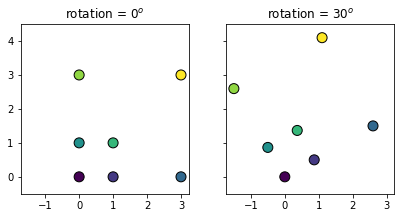

In [21]:
# Generate sample data and Affine Transformation
# https://matplotlib.org/stable/gallery/images_contours_and_fields/affine_image.html

# numpy array
S0 = np.array([[0, 0], [1, 0], [3, 0], [0, 1], [1, 1], [0, 3], [3, 3]])
Sc = np.linspace(0, 1, len(S0))
S1 = Affine2D().rotate_deg(30).transform(S0)

# Visualize
fig_s, axs_s = plt.subplots(ncols=2, figsize=(6, 3), sharex=True, sharey=True)

for ax_s, S, t in zip(axs_s, [S0, S1], [0, 30]):
    ax_s.scatter(S[:, 0], S[:, 1], c=Sc, s=100, ec="k")
       
    ax_s.set_aspect(1)
    ax_s.set_ylim(-0.5, 4.5)
    ax_s.set_title(f"rotation = {t}$^o$", fontsize="large")

fig_s.tight_layout()
fig_s.savefig("92_rougier01_02.png")

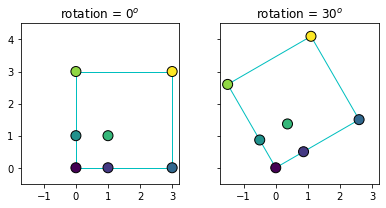

In [22]:
# matplotlib patches
from matplotlib.patches import Rectangle

R0 = Rectangle((0, 0), 3, 3)

for ax_s in axs_s:
    R0 = Rectangle((0, 0), 3, 3, fc="none", ec="c", zorder=-1)
    if ax_s == axs_s[1]:
        Rt = Affine2D().rotate_deg(30) + axs_s[1].transData
        R0.set_transform(Rt)
    ax_s.add_patch(R0)
    
fig_s.tight_layout()
fig_s.savefig("92_rougier01_03.png")
display(fig_s)

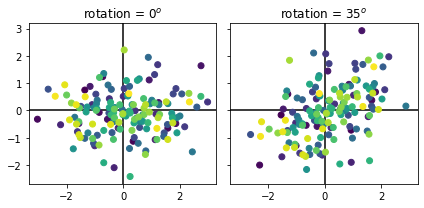

In [23]:
# Generate some data
# Jehyun- I found that you're recycling variables.
#         It might be good to save memories and reduce number of variables, 
#         however, beginners could be confused on reading and understanding code.
#         Therefore I named them separately, i.e. Z0 and Z1.
Z0 = np.random.normal(0, (1.25, 0.75), (150, 2))  # Z0: 2D random points array
Z1 = Affine2D().rotate_deg(35).transform(Z0)      # Z1: rotated Z0
Zm = Z1.mean(axis=0)                              # mean of Z1. Zm = np.array([ 0.13746892, -0.02793329])


# Visualize
fig_r, axs_r = plt.subplots(ncols=2, figsize=(6, 3), sharex=True, sharey=True)
for Z, ax, t in zip([Z0, Z1], axs_r, [0, 35]):
    ax.scatter(Z[:,0], Z[:,1], c=np.linspace(0, 1, Z.shape[0]))
    ax.axhline(0, c="k", zorder=-1)
    ax.axvline(0, c="k", zorder=-1)
    ax.set_title(f"rotation = {t}$^o$", fontsize="large")


Zall = np.concatenate([Z0, Z1])    
xmin, xmax = Zall[:,0].min(), Zall[:,0].max()
ymin, ymax = Zall[:,1].min(), Zall[:,1].max()

axs_s[0].set_xlim(xmin, xmax)

fig_r.tight_layout()
fig_r.savefig("92_rougier01_14.png")

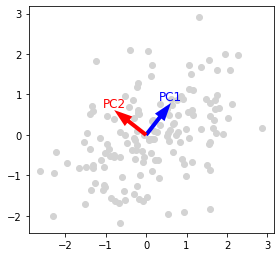

In [24]:
# Principal components analysis
# Note that for some seeds, the PC1 and PC2 needs to be inverted
# It could be fixed by looking at the orientation but I'm lazy
W, V = np.linalg.eig(np.cov(Z1.T))                 # W: eigenvalues, V: eigenvectors
PC1, PC2 = V[np.argsort(abs(W))]                   # PC1, PC2: 1st and 2nd Principal components
if PC2[1] < 0:                                     # to make PC2 "upwards"
    PC2 = -PC2

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(Z1[:,0], Z1[:,1], c="lightgray")

for pc, c in zip(["PC1", "PC2"], ["b", "r"]):
    ax.arrow(0, 0, *eval(pc), width=0.1, length_includes_head=True, ec="none", fc=c)
    ax.text(*eval(pc), pc, ha="center", va="bottom", fontsize="large", color=c)

ax.set_aspect(1)

rotation = 180 * np.arctan2(*PC1) / np.pi

# Jehyun- I believe you made a mistake here.
#         in order to make T as a tangent, the slope should be PC1
# T = np.array([PC1[1], PC1[0]])  # tangent to PCA1
T = np.array([PC1[0], PC1[1]])  # tangent to PCA1 

# Jehyun- Since the PCs are orthogonal each other, PC2 can be used simply.
# O = np.array([T[1], -T[0]])  # orthogonal to PCA1
O = np.array([PC2[0], PC2[1]])  # orthogonal to PCA1

fig.tight_layout()
fig.savefig("92_rougier01_15.png")

In [25]:
print(f"rotation = {rotation}")
print(f"tangent vector = {T}")
print(f"orthogonal vector = {O}")

rotation = 37.89555000213857
tangent vector = [0.61422391 0.78913179]
orthogonal vector = [-0.78913179  0.61422391]


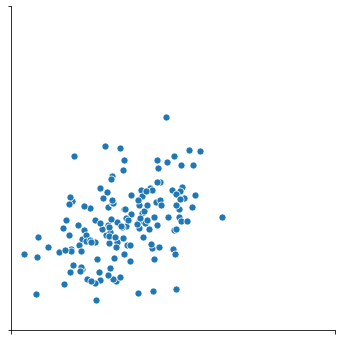

In [26]:
# Draw
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.9], aspect=1)

# Main scatter plot
ax1.scatter(Z1[:, 0], Z1[:, 1], s=50, fc="C0", ec="white", lw=0.75)
ax1.set_xlim([-3, 6])
ax1.set_xticks([-3, 6])
ax1.set_xticklabels([])
ax1.set_ylim([-3, 6])
ax1.set_yticks([-3, 6])
ax1.set_yticklabels([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# fig.tight_layout()
fig.savefig("92_rougier01_04.png")

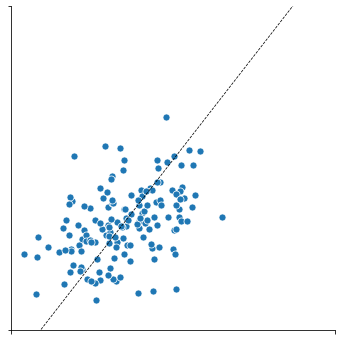

In [27]:
# Draw main PCA axis
P0 = np.vstack([Zm - T * 10, Zm + T * 10])
ax1.plot(P0[:, 0], P0[:, 1], color="black", linestyle="--", linewidth=0.75, zorder=10)
display(fig)

# fig.tight_layout()
fig.savefig("92_rougier01_05.png")

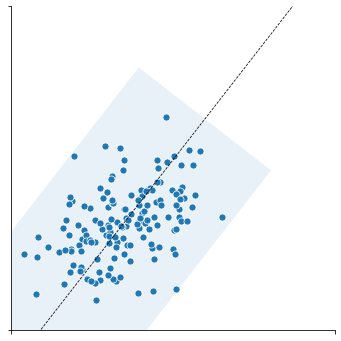

In [28]:
# Compute the width of the distribution along orthogonal direction to the PCA
# main axis. This is made by rotating points and taking max on the Y axis.
transform = Affine2D().rotate_deg(-rotation)
P1 = transform.transform(Z1 - Z1.mean(axis=0))
d = np.abs(P1[:, 1]).max()

# Draw a rectangle surrounding the distribution & oriented along PCA main axis
P2 = np.vstack([Zm - 10 * T - d * O,
                Zm + (6 - d) * T - d * O,
                Zm + (6 - d) * T + d * O,
                Zm - 10 * T + d * O])
ax1.add_patch(
    Polygon(
        P2,
        closed=True,
        fill=True,
        edgecolor="None",
        facecolor="C0",
        alpha=0.1,
        zorder=-50,
    )
)
display(fig)

# fig.tight_layout()
fig.savefig("92_rougier01_06.png")

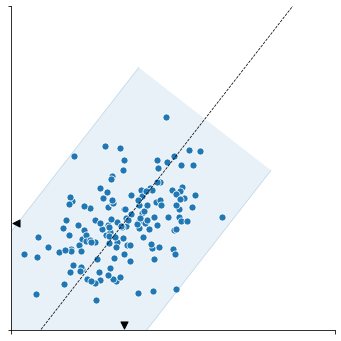

In [29]:
# outlines of the rectangle
P3 = np.vstack([Zm - 10 * T, Zm + (6 - d) * T]) - d * O
ax1.plot(P3[:, 0], P3[:, 1], color="C0", linestyle="-", linewidth=0.75, alpha=0.25)
P4 = np.vstack([Zm - 10 * T, Zm + (6 - d) * T]) + d * O
ax1.plot(P4[:, 0], P4[:, 1], color="C0", linestyle="-", linewidth=0.75, alpha=0.25)

# Some markers on the axis to show the mean (we could compute exactly the delta
# for placing the marker but it is not the point of this example)
ax1.scatter(Zm[0], -2.85, s=50, color="black", marker="v", clip_on=False)
ax1.scatter(-2.85, Zm[1], s=50, color="black", marker="<", clip_on=False)

display(fig)

# fig.tight_layout()
fig.savefig("92_rougier01_07.png")

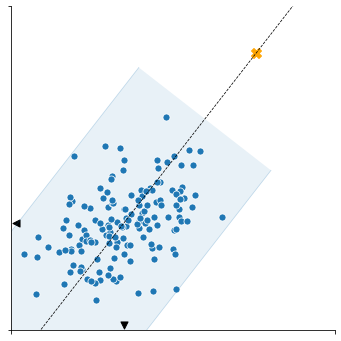

In [30]:
from copy import deepcopy

# Now the complicated stuff to orientate and translate the secondary axis

# 1. Compute the center of the histogram
C = Zm + 6 * T

# Jehyun- I added some annotations and notes to reveal what the code is doing.
ax1.scatter(*C, s=100, c="orange", marker="X", zorder=1)
display(fig)
fig.savefig("92_rougier01_08.png")

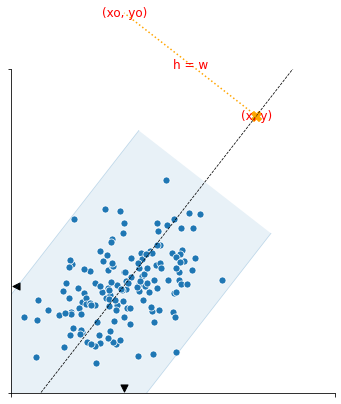

In [31]:
# 2. Compute the coordinate and the size in normalized figure coordinates
x, y = fig.transFigure.inverted().transform(ax1.transData.transform(C))
xo, yo = fig.transFigure.inverted().transform(ax1.transData.transform(C + 2 * d * O))
h = w = np.sqrt((xo - x) ** 2 + (yo - y) ** 2)

import matplotlib.lines as lines

text_xy = fig.text(x, y, "(x, y)", c="r", zorder=1,
                   ha="center", va="center", fontsize="large")
text_xyo = fig.text(xo, yo, "(xo, yo)", c="r", zorder=1,
                    ha="center", va="center", fontsize="large")
line_hw = fig.add_artist(lines.Line2D([x, xo], [y, yo], c="orange", ls=":"))
text_hw = fig.text((x+xo)/2, (y+yo)/2, "h = w", c="r", 
                   ha="center", va="center", fontsize="large")
display(fig)
# Since the annotations exceed boundary of the figure, this part should be screen-captured.
# fig.savefig("92_rougier01_09.png")

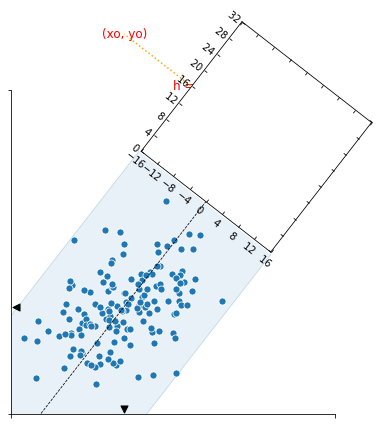

In [32]:
## 3. Create the secondary axis
#    Warning: it must be squared, ie. xmax-xmin = ymax-ymin
#    It is possible to have non squared axis, but it would complicate things.
xmin, xmax = -16, 16
ymin, ymax = 0, xmax - xmin
# Jehyun- Since the tangent vector T is corrected, rotate_deg should be changed, too.
# transform = Affine2D().rotate_deg(rotation - 90)
transform = Affine2D().rotate_deg(-rotation)
helper = floating_axes.GridHelperCurveLinear(transform, (xmin, xmax, ymin, ymax))
ax2 = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper, zorder=0)

# Jehyun- I moved this part to very before plot histogram
# # This auxiliary axis is necessary to draw stuff (no real idea why)
# ax2_aux = ax2.get_aux_axes(transform)

# 4. We know the size of the axis we want but it is rotated. When we specify
#    the size and position, it related to the non-rotate axis and we thus need
#    to compute the bounding box. To do that, we rotate the four coordinates
#    from which we deduce the bounding box coordinates.

# Jehyun- for the same reason, rotate_deg is corrected.
# transform = Affine2D().rotate_deg(rotation - 90)
transform = Affine2D().rotate_deg(-rotation)
R = transform.transform(
    [
        (x - w / 2, y - h / 2),
        (x + w / 2, y - h / 2),
        (x - w / 2, y + h / 2),
        (x + w / 2, y + h / 2),
    ]
)
w = R[:, 0].max() - R[:, 0].min()
h = R[:, 1].max() - R[:, 1].min()
ax2.set_position((x - w / 2, y - h / 2, w, h))

fig.add_subplot(ax2)

# Jehyun- to hide notes behind ax2
for text in fig.texts:
    text.set_zorder(1)
ax2.set_zorder(3)

display(fig)

# Since the annotations exceed boundary of the figure, this part should be screen-captured.
# fig.savefig("92_rougier01_10.png")

ValueError: list.remove(x): x not in list

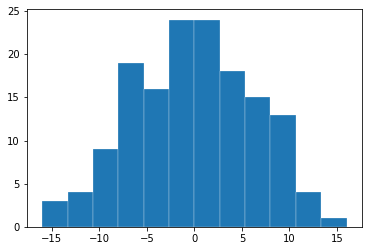

In [39]:
# 5. Some decoration the secondary axis
ax2.axis["left"].major_ticklabels.set_visible(False)
ax2.axis["bottom"].major_ticklabels.set_visible(False)
ax2.axis["bottom"].major_ticks.set_tick_out(True)
ax2.axis["left"].set_visible(False)
ax2.axis["right"].set_visible(False)
ax2.axis["top"].set_visible(False)
ax2.set_xticks([0, 1])
ax2.patch.set_visible(False)

# 6. Display the histogram, taking care of the extents of the X axis
counts, bins = np.histogram(-Z @ PC1, bins=12)
X0 = (bins - bins[0]) / (bins[-1] - bins[0])
X1 = xmin + (xmax - xmin) * X0
Y = np.array(counts)

# Jehyun- if ax2_aux is generated here, no graphical issue appears.
#         previously the output was fine in file, not on screen.
#         I do not know why, but it works.
ax2_aux = ax2.get_aux_axes(transform)
ax2_aux.hist(X1[:-1], X1, weights=Y, facecolor="C0", edgecolor="white", linewidth=0.25)

# Jehyun- remove unnecessary notes
text_xy.remove()
text_xyo.remove()
text_hw.remove()
line_hw.remove()

display(fig)
fig.savefig("92_rougier01_11.png")

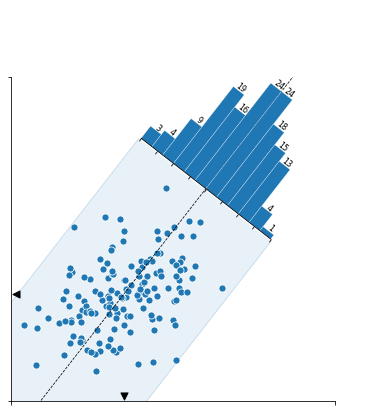

In [34]:
# 7. Adding some labels
dx, dy = (X1[1] - X1[0]) / 2, 0.75
for x, y in zip(X1, Y):
    ax2_aux.text(
        x + dx,
        y + dy,
        "%d" % y,
        ha="center",
        va="center",
        size=8,
        rotation=-rotation,
    )
    
display(fig)
fig.savefig("92_rougier01_12.png")

In [35]:
Zm

array([ 0.13746892, -0.02793329])